In [23]:
import pandas as pd
import os
import sklearn.model_selection as sk_model_selection
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
import sklearn.neural_network as sk_nn
import matplotlib.pyplot as plt

In [24]:
data_dir = './harth'

files = os.listdir(data_dir)

concat = pd.DataFrame()

for root, _, files in os.walk(data_dir):
    for file in files:
        new = pd.read_csv(os.path.join(root, file), index_col = 'timestamp')
        file_name = os.path.splitext(file)[0]
        new['file_name'] = file_name
        concat = pd.concat([concat, new])
label = concat['label']
#concat.drop(labels = ['index', 'Unnamed: 0'], axis = 'columns', inplace = True)
concat.drop(labels = ['index'], axis = 'columns', inplace = True)
concat.reset_index(inplace = True)
concat['timestamp'] = pd.to_datetime(concat['timestamp']).apply(lambda x: x.timestamp())
time = concat['timestamp']

In [27]:
X = concat.drop(columns = ['timestamp', 'label', 'file_name']).dropna()
y = concat.loc[X.index, 'label']
#X = concat[['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']]
#y = concat['label']
scaler = sk_preprocessing.MinMaxScaler(feature_range = (-1,1))
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = sk_model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)

mlp_classifier = sk_nn.MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000)
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)

accuracy = sk_metrics.accuracy_score(y_test, y_pred)

print('Test accuracy: {:0.2f}'.format(accuracy))


Test accuracy: 0.96


In [30]:
cm = sk_metrics.confusion_matrix(y_test, y_pred)
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

def categorize_prediction(row):
    if row['y_test'] == cls and row['y_pred'] == cls:
        return 'TP'
    elif row['y_test'] != cls and row['y_pred'] == cls:
        return 'FP'
    elif row['y_test'] == cls and row['y_pred'] != cls:
        return 'FN'
    else:
        return 'TN'
results_df['category'] = results_df.apply(categorize_prediction, axis=1)

summary = []
classes = sorted(set(y))
print(classes)
for cls in classes:
    tp = ((results_df['y_test'] == cls) & (results_df['y_pred'] == cls)).sum()
    fp = ((results_df['y_test'] != cls) & (results_df['y_pred'] == cls)).sum()
    fn = ((results_df['y_test'] == cls) & (results_df['y_pred'] != cls)).sum()
    tn = ((results_df['y_test'] != cls) & (results_df['y_pred'] != cls)).sum()
    summary.append({'Label': cls, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn})

summary_df = pd.DataFrame(summary)

# Display the summary DataFrame
print(summary_df)

[1, 2, 3, 4, 5, 6, 7, 8]
   Label     TP   FP   FN     TN
0      1  13805  510  355  12860
1      2   4390   45   41  23054
2      3     71   24  330  27105
3      4    579  102   69  26780
4      5    484  162   10  26874
5      6   1254  164  200  25912
6      7   2581    8   25  24916
7      8   3331   20    5  24174


KeyError: 'Class'

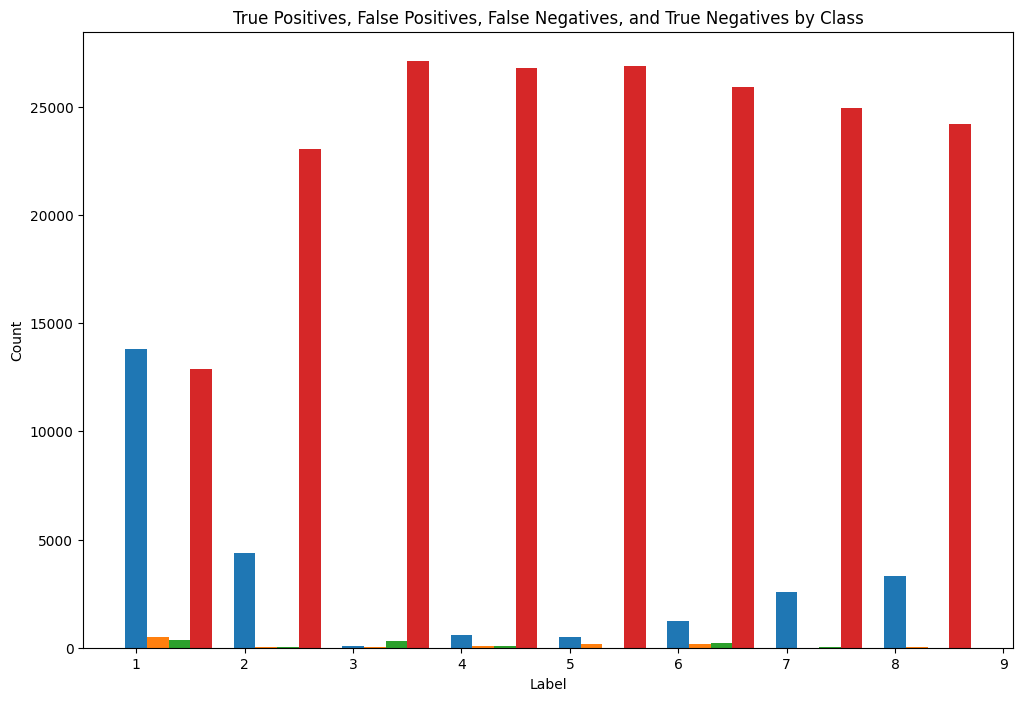

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting bars
bar_width = 0.2
index = summary_df['Label']

bar1 = plt.bar(index, summary_df['TP'], bar_width, label='True Positives')
bar2 = plt.bar(index + bar_width, summary_df['FP'], bar_width, label='False Positives')
bar3 = plt.bar(index + 2 * bar_width, summary_df['FN'], bar_width, label='False Negatives')
bar4 = plt.bar(index + 3 * bar_width, summary_df['TN'], bar_width, label='True Negatives')

# Add labels
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('True Positives, False Positives, False Negatives, and True Negatives by Class')
plt.xticks(index + bar_width, summary_df['Class'])
plt.legend()

# Display the plot
plt.show()